In [16]:
# Getting all the necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
)
import json
from torch_geometric.data import HeteroData
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import pickle
from torch_geometric.explain import Explainer, GNNExplainer
from pyvis.network import Network
import networkx as nx
from IPython.display import display, HTML
import pathlib 

data_fp = '../data/PROCESSED/'
model_fp = '../models'
html_fp = '../figs'

# Create the directory if it doesn't exist
pathlib.Path(model_fp).mkdir(parents=True, exist_ok=True)
# Create the directory for results if it doesn't exist
pathlib.Path(f"{model_fp}/results").mkdir(parents=True, exist_ok=True)
# Create path for figures if it doesn't exist
pathlib.Path(f"{html_fp}").mkdir(parents=True, exist_ok=True)

In [2]:
#Load the heterogeneous graph data
hetero_dict = torch.load(f"{model_fp}/hetero_data_dict_version_final.pt", map_location="cpu")
hetero_data = HeteroData.from_dict(hetero_dict)

# --- Device and Graph Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# --- Model Definition ---
class RGCNLinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all = []
        edge_type_all = []

        for i, (edge_type, edge_index) in enumerate(edge_index_dict.items()):
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))

        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)

        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = self.conv1(x_all, edge_index_cat, edge_type_cat)
        out = F.relu(out)
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

# --- Training Setup ---
in_dim = 128
hidden_dim = 256
out_dim = 128
num_relations = len(edge_types)

model = RGCNLinkPredictor(in_dim, hidden_dim, out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

metrics_log = {
    "train_loss": [],
    "val_loss": [],
    "auc": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": []
}

print("\n[INFO] Starting R-GCN training with Dot Product Decoder and Clean Validation Setup...")

# --- Select One Relation to Supervise ---
edge_type = edge_types[0]
src, dst = hetero_data[edge_type].edge_index
pos_edges = torch.stack([src, dst], dim=1).cpu().numpy()

# --- Train/Validation Positive Split ---
train_pos, val_pos = train_test_split(pos_edges, test_size=0.2, random_state=42)
train_pos = torch.tensor(train_pos, dtype=torch.long).t().to(device)
val_pos = torch.tensor(val_pos, dtype=torch.long).t().to(device)

# --- Precompute Validation Negatives (FIX) ---
z_dummy = torch.cat([hetero_data.x_dict[nt] for nt in hetero_data.node_types], dim=0)
fixed_val_neg = negative_sampling(
    edge_index=val_pos,
    num_nodes=z_dummy.size(0),
    num_neg_samples=val_pos.size(1)
).to(device)

# --- Training Loop ---
for epoch in range(1, 401):
    model.train()
    optimizer.zero_grad()

    z = model(hetero_data.x_dict, hetero_data.edge_index_dict)

    # --- Sample Training Negatives ---
    neg_train = negative_sampling(
        edge_index=train_pos,
        num_nodes=z.size(0),
        num_neg_samples=train_pos.size(1)
    )

    train_edges = torch.cat([train_pos, neg_train], dim=1)
    train_labels = torch.cat([
        torch.ones(train_pos.size(1), device=device),
        torch.zeros(neg_train.size(1), device=device)
    ])

    train_src = z[train_edges[0]]
    train_dst = z[train_edges[1]]
    train_pred = (train_src * train_dst).sum(dim=-1)

    loss = criterion(train_pred, train_labels)
    loss.backward()
    optimizer.step()

    # --- Validation (Fixed Negatives) ---
    model.eval()
    with torch.no_grad():
        val_edges = torch.cat([val_pos, fixed_val_neg], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos.size(1), device=device),
            torch.zeros(fixed_val_neg.size(1), device=device)
        ])

        val_src = z[val_edges[0]]
        val_dst = z[val_edges[1]]
        val_pred = (val_src * val_dst).sum(dim=-1)

        val_loss = criterion(val_pred, val_labels).item()
        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        y_true = val_labels.cpu().numpy()

        metrics_log["train_loss"].append(loss.item())
        metrics_log["val_loss"].append(val_loss)
        metrics_log["auc"].append(roc_auc_score(y_true, val_probs))
        metrics_log["f1_score"].append(f1_score(y_true, val_preds))
        metrics_log["precision"].append(precision_score(y_true, val_preds))
        metrics_log["recall"].append(recall_score(y_true, val_preds))
        metrics_log["accuracy"].append(accuracy_score(y_true, val_preds))

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | AUC: {metrics_log['auc'][-1]:.4f}")

# --- Save Model and Metrics ---
torch.save(model.state_dict(), f"{model_fp}/rgcn_dotprod_v4.pt")
with open(f"{model_fp}/results/rgcn_dotprod_metrics.json", "w") as f:
    json.dump(metrics_log, f)

print("\n Training complete and metrics saved.")


/tmp/ipykernel_17247/4289240537.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hetero_dict = torch.load(f"{model_fp}/hetero_data_dict_version_final.pt", map_location="c


[INFO] Starting R-GCN training with Dot Product Decoder and Clean Validation Setup...
Epoch 010 | Train Loss: 1.7927 | Val Loss: 1.7926 | AUC: 0.8535
Epoch 020 | Train Loss: 0.7817 | Val Loss: 0.7831 | AUC: 0.9389
Epoch 030 | Train Loss: 0.5011 | Val Loss: 0.5019 | AUC: 0.9800
Epoch 040 | Train Loss: 0.4346 | Val Loss: 0.4351 | AUC: 0.9855
Epoch 050 | Train Loss: 0.4180 | Val Loss: 0.4187 | AUC: 0.9878
Epoch 060 | Train Loss: 0.4079 | Val Loss: 0.4089 | AUC: 0.9894
Epoch 070 | Train Loss: 0.4002 | Val Loss: 0.4045 | AUC: 0.9900
Epoch 080 | Train Loss: 0.3998 | Val Loss: 0.4022 | AUC: 0.9905
Epoch 090 | Train Loss: 0.3974 | Val Loss: 0.4005 | AUC: 0.9909
Epoch 100 | Train Loss: 0.3945 | Val Loss: 0.3992 | AUC: 0.9912
Epoch 110 | Train Loss: 0.3942 | Val Loss: 0.3981 | AUC: 0.9915
Epoch 120 | Train Loss: 0.3935 | Val Loss: 0.3972 | AUC: 0.9918
Epoch 130 | Train Loss: 0.3912 | Val Loss: 0.3964 | AUC: 0.9919
Epoch 140 | Train Loss: 0.3907 | Val Loss: 0.3954 | AUC: 0.9922
Epoch 150 | Train

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

class RGCNLinkEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)
        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = F.relu(self.conv1(x_all, edge_index_cat, edge_type_cat))
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Model setup
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)
encoder = RGCNLinkEncoder(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

# Metric tracking
train_loss_list, val_loss_list = [], []
f1_list, precision_list, recall_list, accuracy_list, auc_list = [], [], [], [], []

print("\n[INFO] Starting R-GCN + DistMult training with fixed val negatives...")

# Use a single relation type for supervision
edge_type = edge_types[0]
rel_id = relation_to_id[edge_type]
src, dst = hetero_data[edge_type].edge_index
pos_edge_index = torch.stack([src, dst], dim=0)

# Train/val split on positive edges
pos_edge_np = pos_edge_index.cpu().numpy().T
train_pos_np, val_pos_np = train_test_split(pos_edge_np, test_size=0.2, random_state=42)
train_pos_edge = torch.tensor(train_pos_np.T, dtype=torch.long, device=device)
val_pos_edge = torch.tensor(val_pos_np.T, dtype=torch.long, device=device)

# Fixed val negatives
num_nodes = torch.cat([x for x in hetero_data.x_dict.values()], dim=0).shape[0]
fixed_val_neg = negative_sampling(val_pos_edge, num_nodes=num_nodes, num_neg_samples=val_pos_edge.shape[1])

# Training loop
for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    z = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)

    # Sample new train negatives
    neg_train_edge = negative_sampling(train_pos_edge, num_nodes=z.size(0), num_neg_samples=train_pos_edge.shape[1])
    train_edge_index = torch.cat([train_pos_edge, neg_train_edge], dim=1)
    train_labels = torch.cat([
        torch.ones(train_pos_edge.shape[1], device=device),
        torch.zeros(neg_train_edge.shape[1], device=device)
    ])
    edge_type_ids_train = torch.full((train_edge_index.shape[1],), rel_id, dtype=torch.long, device=device)
    train_pred = decoder(z, train_edge_index, edge_type_ids_train)
    train_loss = criterion(train_pred, train_labels)
    train_loss.backward()
    optimizer.step()

    # Evaluation on fixed val edges
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        val_edge_index = torch.cat([val_pos_edge, fixed_val_neg], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos_edge.shape[1], device=device),
            torch.zeros(fixed_val_neg.shape[1], device=device)
        ])
        edge_type_ids_val = torch.full((val_edge_index.shape[1],), rel_id, dtype=torch.long, device=device)
        val_pred = decoder(z, val_edge_index, edge_type_ids_val)
        val_loss = criterion(val_pred, val_labels)

        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        y_true = val_labels.cpu().numpy()

        auc = roc_auc_score(y_true, val_probs)
        acc = accuracy_score(y_true, val_preds)
        precision = precision_score(y_true, val_preds)
        recall = recall_score(y_true, val_preds)
        f1 = f1_score(y_true, val_preds)

        train_loss_list.append(train_loss.item())
        val_loss_list.append(val_loss.item())
        auc_list.append(auc)
        accuracy_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | AUC: {auc:.4f}")

# Save model and metrics
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, f"{model_fp}/rgcn_distmult_v4_metrics.pt")

with open(f"{model_fp}/results/rgcn_distmult_metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list,
        "roc_auc": auc_list
    }, f)

print("\nTraining complete. Model and metrics saved.")



[INFO] Starting R-GCN + DistMult training with fixed val negatives...
Epoch 010 | Train Loss: 1.6725 | Val Loss: 1.6774 | AUC: 0.9631
Epoch 020 | Train Loss: 0.2796 | Val Loss: 0.2973 | AUC: 0.9874
Epoch 030 | Train Loss: 0.2740 | Val Loss: 0.2840 | AUC: 0.9899
Epoch 040 | Train Loss: 0.1321 | Val Loss: 0.1519 | AUC: 0.9906
Epoch 050 | Train Loss: 0.1183 | Val Loss: 0.1479 | AUC: 0.9899
Epoch 060 | Train Loss: 0.0904 | Val Loss: 0.1130 | AUC: 0.9914
Epoch 070 | Train Loss: 0.0856 | Val Loss: 0.1038 | AUC: 0.9923
Epoch 080 | Train Loss: 0.0767 | Val Loss: 0.0999 | AUC: 0.9927
Epoch 090 | Train Loss: 0.0723 | Val Loss: 0.0981 | AUC: 0.9930
Epoch 100 | Train Loss: 0.0680 | Val Loss: 0.0960 | AUC: 0.9934
Epoch 110 | Train Loss: 0.0647 | Val Loss: 0.0937 | AUC: 0.9937
Epoch 120 | Train Loss: 0.0602 | Val Loss: 0.0920 | AUC: 0.9940
Epoch 130 | Train Loss: 0.0588 | Val Loss: 0.0909 | AUC: 0.9943
Epoch 140 | Train Loss: 0.0564 | Val Loss: 0.0890 | AUC: 0.9945
Epoch 150 | Train Loss: 0.0540 | 

In [4]:
# Assume hetero_data is already defined and loaded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

class RGCNLinkEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)

    def forward(self, x, edge_index_dict):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)
        x_all = torch.cat([x[nt] for nt in hetero_data.node_types], dim=0)
        out = F.relu(self.conv1(x_all, edge_index_cat, edge_type_cat))
        out = self.conv2(out, edge_index_cat, edge_type_cat)
        return out

class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Hyperparameters
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)

# Model and optimizer
encoder = RGCNLinkEncoder(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.005)
criterion = nn.BCEWithLogitsLoss()

metrics = {
    et: {
        "train_loss": [], "val_loss": [], "accuracy": [],
        "precision": [], "recall": [], "f1_score": [], "roc_auc": []
    }
    for et in edge_types
}

print("\n[INFO] Starting clean multi-relation DistMult training...")

for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    z = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)
    total_loss = 0

    for edge_type in edge_types:
        rel_id = relation_to_id[edge_type]
        src, dst = hetero_data[edge_type].edge_index
        if src.size(0) == 0:
            continue

        # Step 1: Split positives first
        pos_edges_np = torch.stack([src, dst], dim=1).cpu().numpy()
        train_pos_np, val_pos_np = train_test_split(pos_edges_np, test_size=0.2, random_state=42)
        train_pos = torch.tensor(train_pos_np.T, dtype=torch.long, device=device)
        val_pos = torch.tensor(val_pos_np.T, dtype=torch.long, device=device)

        # Step 2: Sample negatives after split
        neg_train = negative_sampling(train_pos, num_nodes=z.size(0), num_neg_samples=train_pos.shape[1])
        neg_val = negative_sampling(val_pos, num_nodes=z.size(0), num_neg_samples=val_pos.shape[1])

        # Step 3: Prepare train and val edge-label sets
        train_edges = torch.cat([train_pos, neg_train], dim=1)
        train_labels = torch.cat([
            torch.ones(train_pos.shape[1], device=device),
            torch.zeros(neg_train.shape[1], device=device)
        ])
        val_edges = torch.cat([val_pos, neg_val], dim=1)
        val_labels = torch.cat([
            torch.ones(val_pos.shape[1], device=device),
            torch.zeros(neg_val.shape[1], device=device)
        ])
        edge_type_train = torch.full((train_edges.shape[1],), rel_id, dtype=torch.long, device=device)
        edge_type_val = torch.full((val_edges.shape[1],), rel_id, dtype=torch.long, device=device)

        # Step 4: Forward and loss
        train_pred = decoder(z, train_edges, edge_type_train)
        val_pred = decoder(z, val_edges, edge_type_val)
        train_loss = criterion(train_pred, train_labels)
        val_loss = criterion(val_pred, val_labels)
        total_loss += train_loss

        # Step 5: Metrics
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            val_probs = torch.sigmoid(val_pred).cpu().numpy()
            val_preds = (val_probs > 0.5).astype(int)
            y_true = val_labels.cpu().numpy()

            try:
                auc = roc_auc_score(y_true, val_probs)
            except:
                auc = 0.0

            metrics[edge_type]["train_loss"].append(train_loss.item())
            metrics[edge_type]["val_loss"].append(val_loss.item())
            metrics[edge_type]["roc_auc"].append(auc)
            metrics[edge_type]["accuracy"].append(accuracy_score(y_true, val_preds))
            metrics[edge_type]["precision"].append(precision_score(y_true, val_preds, zero_division=0))
            metrics[edge_type]["recall"].append(recall_score(y_true, val_preds, zero_division=0))
            metrics[edge_type]["f1_score"].append(f1_score(y_true, val_preds, zero_division=0))

    if total_loss != 0:
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Avg Train Loss: {total_loss.item():.4f}")

# Save
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, f"{model_fp}/rgcn_distmult_multirel_metrics.pt")

with open(f"{model_fp}/results/rgcn_distmult_multirel_metrics.json", "w") as f:
    json.dump({str(k): v for k, v in metrics.items()}, f)

print("\n Training complete with clean train/val split. Model and metrics saved.")



[INFO] Starting clean multi-relation DistMult training...
Epoch 010 | Avg Train Loss: 4.2308
Epoch 020 | Avg Train Loss: 2.0312
Epoch 030 | Avg Train Loss: 1.2633
Epoch 040 | Avg Train Loss: 0.9966
Epoch 050 | Avg Train Loss: 0.8565
Epoch 060 | Avg Train Loss: 0.7874
Epoch 070 | Avg Train Loss: 0.7346
Epoch 080 | Avg Train Loss: 0.7004
Epoch 090 | Avg Train Loss: 0.6776
Epoch 100 | Avg Train Loss: 0.6444
Epoch 110 | Avg Train Loss: 0.6311
Epoch 120 | Avg Train Loss: 0.6068
Epoch 130 | Avg Train Loss: 0.5989
Epoch 140 | Avg Train Loss: 0.5868
Epoch 150 | Avg Train Loss: 0.5704
Epoch 160 | Avg Train Loss: 0.5611
Epoch 170 | Avg Train Loss: 0.5447
Epoch 180 | Avg Train Loss: 0.5361
Epoch 190 | Avg Train Loss: 0.5290
Epoch 200 | Avg Train Loss: 0.5168
Epoch 210 | Avg Train Loss: 0.5122
Epoch 220 | Avg Train Loss: 0.4928
Epoch 230 | Avg Train Loss: 0.4991
Epoch 240 | Avg Train Loss: 0.4905
Epoch 250 | Avg Train Loss: 0.4734
Epoch 260 | Avg Train Loss: 0.4698
Epoch 270 | Avg Train Loss: 0.4

In [5]:
# Device & data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hetero_data = hetero_data.to(device)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# === R-GCN Encoder with Global Pooling ===
class RGCNLinkEncoderWithGlobal(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, out_dim, num_relations)
        self.global_pool = global_mean_pool

    def forward(self, x, edge_index_dict, batch=None):
        edge_index_all, edge_type_all = [], []
        for edge_type, edge_index in edge_index_dict.items():
            rel_id = relation_to_id[edge_type]
            edge_index_all.append(edge_index)
            edge_type_all.append(torch.full((edge_index.size(1),), rel_id, dtype=torch.long, device=edge_index.device))
        edge_index_cat = torch.cat(edge_index_all, dim=1)
        edge_type_cat = torch.cat(edge_type_all, dim=0)

        x_all = torch.cat([x[ntype] for ntype in hetero_data.node_types], dim=0)
        out = self.conv1(x_all, edge_index_cat, edge_type_cat)
        out = F.relu(out)
        out = self.conv2(out, edge_index_cat, edge_type_cat)

        if batch is None:
            batch = torch.zeros(out.size(0), dtype=torch.long, device=out.device)

        global_feat = self.global_pool(out, batch)
        return out, global_feat

# === DistMult Decoder ===
class DistMultDecoder(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super().__init__()
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

    def forward(self, z, edge_label_index, edge_type_ids):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.relation_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# === Model Setup ===
in_dim, hidden_dim, out_dim = 128, 256, 128
num_relations = len(edge_types)

encoder = RGCNLinkEncoderWithGlobal(in_dim, hidden_dim, out_dim, num_relations).to(device)
decoder = DistMultDecoder(out_dim, num_relations).to(device)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.005)

# If needed, use weighted loss for class imbalance
# pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss()  # or: nn.BCEWithLogitsLoss(pos_weight=pos_weight)

metrics_dict = {
    "train_loss": [], "val_loss": [],
    "accuracy": [], "precision": [],
    "recall": [], "f1_score": [], "roc_auc": []
}

print("\n[INFO] Starting Final Enhanced R-GCN with Global Pooling and DistMult Decoder...")

# === Use one relation for binary link prediction ===
edge_type = edge_types[0]
rel_id = relation_to_id[edge_type]
src, dst = hetero_data[edge_type].edge_index
pos_edge_index = torch.stack([src, dst], dim=0)

neg_edge_index = negative_sampling(pos_edge_index, num_nodes=hetero_data.x_dict['protein'].shape[0], num_neg_samples=pos_edge_index.shape[1])
edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
edge_label = torch.cat([
    torch.ones(pos_edge_index.size(1), device=device),
    torch.zeros(neg_edge_index.size(1), device=device)
])

edge_idx = np.arange(edge_label_index.shape[1])
train_idx, val_idx = train_test_split(edge_idx, test_size=0.2, random_state=42)

# === Training Loop ===
for epoch in range(1, 401):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    z, _ = encoder(hetero_data.x_dict, hetero_data.edge_index_dict)
    edge_type_ids = torch.full((edge_label_index.shape[1],), rel_id, dtype=torch.long, device=device)
    pred = decoder(z, edge_label_index, edge_type_ids)

    train_pred = pred[train_idx]
    train_label = edge_label[train_idx]
    val_pred = pred[val_idx]
    val_label = edge_label[val_idx]

    train_loss = criterion(train_pred, train_label)
    val_loss = criterion(val_pred, val_label)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_probs = torch.sigmoid(val_pred).cpu().numpy()
        val_preds = (val_probs > 0.5).astype(int)
        val_labels = val_label.cpu().numpy()

        auc = roc_auc_score(val_labels, val_probs)
        acc = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds, zero_division=0)
        recall = recall_score(val_labels, val_preds, zero_division=0)
        f1 = f1_score(val_labels, val_preds, zero_division=0)

        metrics_dict["train_loss"].append(train_loss.item())
        metrics_dict["val_loss"].append(val_loss.item())
        metrics_dict["roc_auc"].append(auc)
        metrics_dict["accuracy"].append(acc)
        metrics_dict["precision"].append(precision)
        metrics_dict["recall"].append(recall)
        metrics_dict["f1_score"].append(f1)

        if epoch % 10 == 0:
            pos_count = np.sum(val_preds)
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | AUC: {auc:.4f} | Positives: {pos_count}/{len(val_preds)}")

# === Save Results ===
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'relation_to_id': relation_to_id
}, f"{model_fp}/rgcn_global_pool_distmult_v2.pt")

with open(f"{model_fp}/results/rgcn_global_pool_distmult_metrics.json", "w") as f:
    json.dump(metrics_dict, f)

print("Saved model and evaluation metrics.")



[INFO] Starting Final Enhanced R-GCN with Global Pooling and DistMult Decoder...
Epoch 010 | Train Loss: 2.3678 | Val Loss: 2.4590 | AUC: 0.8785 | Positives: 29928/60367
Epoch 020 | Train Loss: 0.9238 | Val Loss: 1.0196 | AUC: 0.8880 | Positives: 30543/60367
Epoch 030 | Train Loss: 0.5129 | Val Loss: 0.5922 | AUC: 0.8649 | Positives: 39939/60367
Epoch 040 | Train Loss: 0.3425 | Val Loss: 0.4147 | AUC: 0.9070 | Positives: 33140/60367
Epoch 050 | Train Loss: 0.2979 | Val Loss: 0.3732 | AUC: 0.9210 | Positives: 30202/60367
Epoch 060 | Train Loss: 0.2730 | Val Loss: 0.3498 | AUC: 0.9272 | Positives: 28769/60367
Epoch 070 | Train Loss: 0.2486 | Val Loss: 0.3356 | AUC: 0.9336 | Positives: 29543/60367
Epoch 080 | Train Loss: 0.2283 | Val Loss: 0.3247 | AUC: 0.9378 | Positives: 29999/60367
Epoch 090 | Train Loss: 0.2109 | Val Loss: 0.3159 | AUC: 0.9412 | Positives: 30080/60367
Epoch 100 | Train Loss: 0.1948 | Val Loss: 0.3096 | AUC: 0.9443 | Positives: 30288/60367
Epoch 110 | Train Loss: 0.18

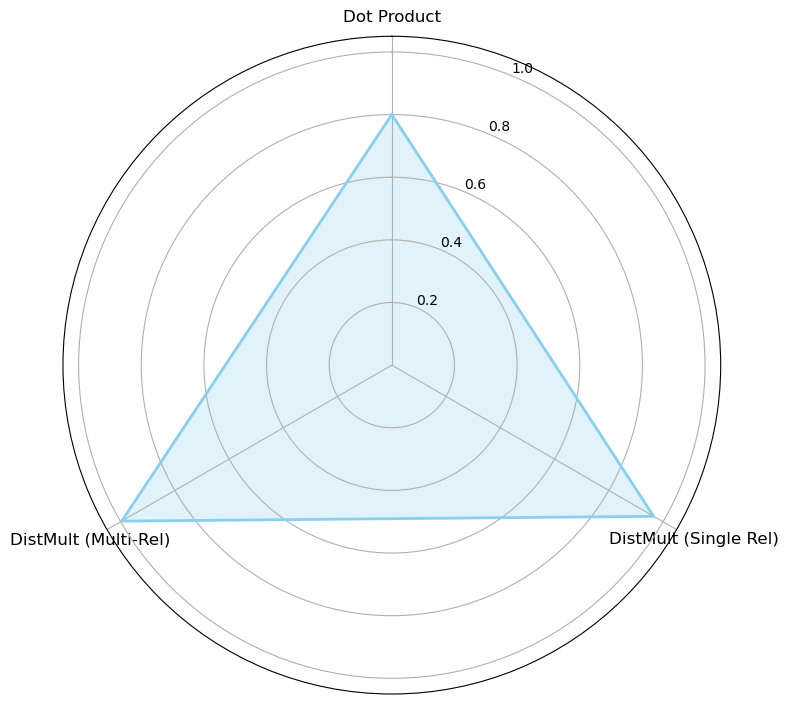

In [6]:
# Reload the metrics
paths = {
    "Dot Product": f"{model_fp}/results/rgcn_dotprod_metrics.json",
    "DistMult (Single Rel)": f"{model_fp}/results/rgcn_distmult_metrics.json",
    "DistMult (Multi-Rel)": f"{model_fp}/results/rgcn_distmult_multirel_metrics.json"
}

# Relation to focus on
target_relation = "('drug', 'drug_effect', 'phenotype')"

# Extract F1 scores
f1_scores = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        data = json.load(f)

        if isinstance(data.get("f1_score"), list):
            f1_scores[model_name] = data["f1_score"][-1]
        elif target_relation in data and "f1_score" in data[target_relation]:
            f1_scores[model_name] = data[target_relation]["f1_score"][-1]

if len(f1_scores) < 2:
    raise ValueError("Need at least two models with valid F1 scores to plot.")

# Extract labels and scores
labels = list(f1_scores.keys())
scores = list(f1_scores.values())

# Generate angles
angles = np.linspace(0, 2 * np.pi, len(scores), endpoint=False).tolist()

# Close the circle for plotting
scores += scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.plot(angles, scores, linewidth=2, linestyle='solid', color='#89CFF0')
ax.fill(angles, scores, color='#89CFF0', alpha=0.25)

# Use original labels (not repeated) for theta grid
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
ax.set_ylim(0, 1.05)

ax.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Load metrics from multi-relational model
path = f"{model_fp}/results/rgcn_distmult_multirel_metrics.json"
with open(path, "r") as f:
    data = json.load(f)

# Extract final values of multiple metrics for each relation
metrics_to_extract = ["f1_score", "roc_auc", "precision", "recall", "accuracy"]
rows = []

for relation, metrics in data.items():
    row = {"Relation": str(relation)}
    for metric in metrics_to_extract:
        if metric in metrics:
            row[metric] = metrics[metric][-1]
    rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)
df.set_index("Relation", inplace=True)
df = df[metrics_to_extract]  # ensure column order

# Melt for plotly heatmap
df_reset = df.reset_index().melt(id_vars="Relation", var_name="Metric", value_name="Score")

# Plotly heatmap
fig = px.imshow(
    df.values,
    labels=dict(x="Metric", y="Relation", color="Score"),
    x=metrics_to_extract,
    y=df.index,
    color_continuous_scale="viridis",
    text_auto=".3f"
)


fig.update_layout(
    title=" Interactive Heatmap of Metrics per Relation (DistMult Multi-Rel)",
    title_font_size=20,
    xaxis_title="Metric",
    yaxis_title="Relation",
    height=500 + len(df) * 25,
    margin=dict(l=50, r=50, t=80, b=50)
)




fig.show()


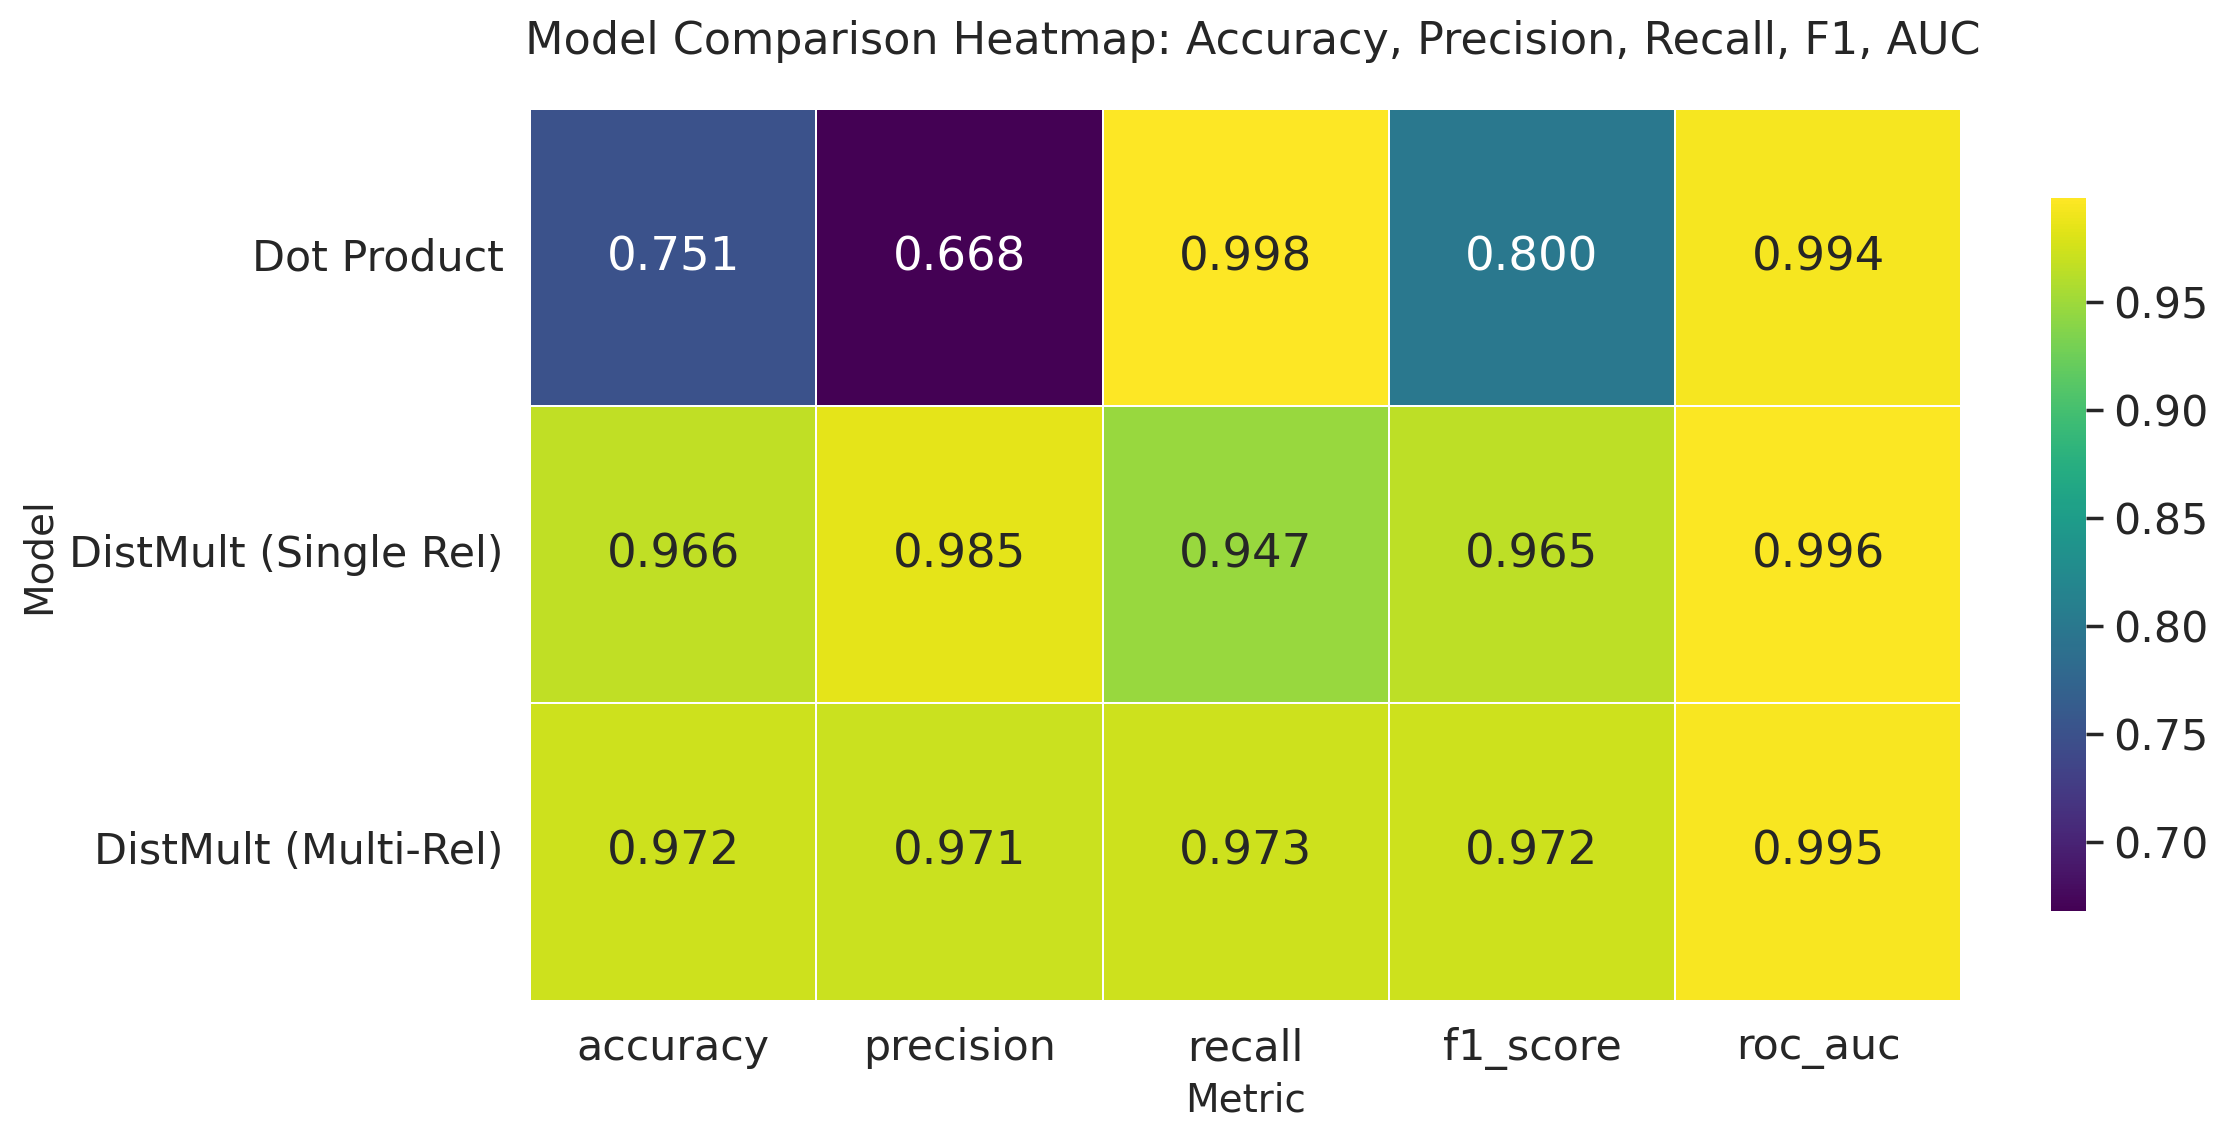

In [8]:
# File paths
paths = {
    "Dot Product": f"{model_fp}/results/rgcn_dotprod_metrics.json",
    "DistMult (Single Rel)": f"{model_fp}/results/rgcn_distmult_metrics.json",
    "DistMult (Multi-Rel)": f"{model_fp}/results/rgcn_distmult_multirel_metrics.json"
}

# Unified list of metrics
metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]
target_relation = "('disease', 'disease_phenotype_positive', 'phenotype')"

# Map AUC inconsistencies
alternate_auc_key = {
    "Dot Product": "auc",
    "DistMult (Single Rel)": "roc_auc",
    "DistMult (Multi-Rel)": "roc_auc"
}

# Extract and normalize metrics
scores = {}
for model, path in paths.items():
    with open(path, "r") as f:
        data = json.load(f)

    row = {}
    for metric in metrics:
        key = metric
        if metric == "roc_auc":
            key = alternate_auc_key[model]  # Fix for Dot Product

        if model == "DistMult (Multi-Rel)":
            if target_relation in data and key in data[target_relation]:
                row[metric] = data[target_relation][key][-1]
        else:
            if key in data:
                row[metric] = data[key][-1]
    scores[model] = row

# Create DataFrame
df = pd.DataFrame(scores).T
df = df[metrics]

# Plot the heatmap
plt.figure(figsize=(12, 6), dpi=200)
sns.set(font_scale=1.4)
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap="viridis", linewidths=0.6, cbar_kws={"shrink": 0.8})

plt.title(" Model Comparison Heatmap: Accuracy, Precision, Recall, F1, AUC", fontsize=16, pad=20)
plt.ylabel("Model", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Load data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hetero_dict = torch.load("./hetero_data_dict.pt", map_location=device)
hetero_dict = torch.load(f"{model_fp}/hetero_data_dict_version_final.pt", map_location=device)


hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open(f"{data_fp}/node_maps_version_final.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# Define R-GCN encoder
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

# Dot Product predictor
class DotProductPredictor(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, edge_type, edge_label_index):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

# Load trained encoder
encoder = RGCNEncoder(128, 256, 128, len(edge_types)).to(device)
encoder.load_state_dict(torch.load(f"{model_fp}/rgcn_dotprod_v4.pt", map_location=device))
predictor = DotProductPredictor(encoder).to(device)
predictor.eval()

# Choose nodes to explain
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)

# Prepare graph inputs
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all = []
edge_type_all = []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# Setup GNNExplainer
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

# Run explanation
explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index
)

# Visualize explanation
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[int(idx)] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u = int(u)
        v = int(v)
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))

        G.add_node(u, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u, v)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show(f"{html_fp}/gnn_explanation_dotprod.html")


# Show subgraph
display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# Score on full graph
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# Score on subgraph only
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")


/tmp/ipykernel_17247/1297510550.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_17247/1297510550.py:42: FutureWarning:

You are using `torch.load` with `w

./gnn_explanation_dotprod.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.9995
 Confidence score using only GNNExplainer's subgraph: 1.0000


In [18]:
# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load graph + metadata ===
hetero_dict = torch.load(f"{model_fp}/hetero_data_dict_version_final.pt", map_location=device)
hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open(f"{data_fp}/node_maps_version_final.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# === Define models ===
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

class DistMultPredictor(torch.nn.Module):
    def __init__(self, encoder, embedding_dim, num_relations):
        super().__init__()
        self.encoder = encoder
        self.rel_embeddings = torch.nn.Embedding(num_relations, embedding_dim)

    def forward(self, x, edge_index, edge_type, edge_label_index, edge_type_ids):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.rel_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# === Load model checkpoint ===
ckpt = torch.load(f"{model_fp}/rgcn_distmult_v4_metrics.pt", map_location=device)
encoder = RGCNEncoder(128, 256, 128, len(edge_types)).to(device)
encoder.load_state_dict(ckpt['encoder_state_dict'])

predictor = DistMultPredictor(encoder, 128, len(edge_types)).to(device)
predictor.rel_embeddings.load_state_dict({'weight': ckpt['decoder_state_dict']['relation_embeddings.weight']})
predictor.eval()

# === Define query ===
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
rel = ("disease", "disease_phenotype_positive", "phenotype")
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)
rel_id = torch.tensor([relation_to_id[rel]], device=device)

# === Prepare graph input ===
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all, edge_type_all = [], []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# === Run GNNExplainer ===
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index,
    edge_type_ids=rel_id
)

# === Visualize explanation ===
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[int(idx)] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u = int(u)
        v = int(v)
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))

        G.add_node(u, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u, v)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show(f"{html_fp}/gnn_explanation_distmult_single.html")

display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# === Score on full graph ===
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# === Score on subgraph only ===
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")


/tmp/ipykernel_17247/2513631574.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_17247/2513631574.py:41: FutureWarning:

You are using `torch.load` with `w

../figs/gnn_explanation_distmult_single.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.9999
 Confidence score using only GNNExplainer's subgraph: 1.0000


In [ ]:
# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load hetero data
hetero_dict = torch.load(f"{model_fp}/hetero_data_dict_version_final.pt", map_location=device)
hetero_data = HeteroData.from_dict(hetero_dict).to(device)

with open(f"{data_fp}/node_maps_version_final.pkl", "rb") as f:
    node_maps = pickle.load(f)

edge_types = list(hetero_data.edge_types)
relation_to_id = {rel: i for i, rel in enumerate(edge_types)}

# Encoder model
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

# DistMult predictor
class DistMultPredictor(torch.nn.Module):
    def __init__(self, encoder, embedding_dim, num_relations):
        super().__init__()
        self.encoder = encoder
        self.rel_embeddings = torch.nn.Embedding(num_relations, embedding_dim)

    def forward(self, x, edge_index, edge_type, edge_label_index, edge_type_ids):
        z = self.encoder(x, edge_index, edge_type)
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        rel = self.rel_embeddings(edge_type_ids)
        return (src * rel * dst).sum(dim=-1)

# Load trained model
embedding_dim = 128
encoder = RGCNEncoder(128, 256, embedding_dim, len(edge_types)).to(device)
decoder_ckpt = torch.load(f"{model_fp}/rgcn_distmult_multirel_metrics.pt", map_location=device)

encoder.load_state_dict(decoder_ckpt['encoder_state_dict'])

predictor = DistMultPredictor(encoder, embedding_dim, len(edge_types)).to(device)
predictor.rel_embeddings.load_state_dict({'weight': decoder_ckpt['decoder_state_dict']['relation_embeddings.weight']})
predictor.eval()

# Choose link to explain
disease = "permanent neonatal diabetes mellitus"
phenotype = "retinopathy"
rel = ("disease", "disease_phenotype_positive", "phenotype")
src_idx = node_maps["disease"].get(disease)
dst_idx = node_maps["phenotype"].get(phenotype)
rel_id = torch.tensor([relation_to_id[rel]], device=device)

# Prepare input
all_x = torch.cat([hetero_data[n].x for n in hetero_data.node_types], dim=0)

edge_index_all = []
edge_type_all = []
for etype, eidx in hetero_data.edge_index_dict.items():
    rel_index = relation_to_id[etype]
    edge_index_all.append(eidx)
    edge_type_all.append(torch.full((eidx.size(1),), rel_index, dtype=torch.long, device=device))

edge_index_cat = torch.cat(edge_index_all, dim=1)
edge_type_cat = torch.cat(edge_type_all)

# Setup GNNExplainer
explainer = Explainer(
    model=predictor,
    algorithm=GNNExplainer(epochs=100),
    explanation_type="model",
    edge_mask_type="object",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="raw",
    ),
)

edge_label_index = torch.tensor([[src_idx], [dst_idx]], device=device)

# Run explanation
explanation = explainer(
    x=all_x,
    edge_index=edge_index_cat,
    edge_type=edge_type_cat,
    edge_label_index=edge_label_index,
    edge_type_ids=rel_id
)

# Visualize explanation subgraph
def display_explanation_subgraph(explanation, edge_index, node_maps, top_k=15):
    edge_mask = explanation.edge_mask
    topk = edge_mask.topk(top_k)
    selected_edges = edge_index[:, topk.indices].cpu().numpy()

    reverse_node_map = {}
    for node_type, mapping in node_maps.items():
        for name, idx in mapping.items():
            reverse_node_map[idx] = (name, node_type)

    G = nx.DiGraph()
    for u, v in zip(selected_edges[0], selected_edges[1]):
        u_name, u_type = reverse_node_map.get(u, (str(u), "unknown"))
        v_name, v_type = reverse_node_map.get(v, (str(v), "unknown"))
        u_id = int(u)
        v_id = int(v)
        G.add_node(u_id, label=u_name, title=f"{u_name} ({u_type})", group=u_type)
        G.add_node(v_id, label=v_name, title=f"{v_name} ({v_type})", group=v_type)
        G.add_edge(u_id, v_id)

    net = Network(height="600px", width="100%", notebook=True, directed=True, cdn_resources="in_line")
    net.from_nx(G)
    net.show(f"{html_fp}/gnn_explanation_multirel_v3.html")

# Call visualization
display_explanation_subgraph(explanation, edge_index_cat, node_maps)

# Confidence score (full graph)
with torch.no_grad():
    full_score = predictor(
        x=all_x,
        edge_index=edge_index_cat,
        edge_type=edge_type_cat,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    full_prob = torch.sigmoid(full_score).item()
    print(f"\n Full graph prediction score for '{disease}' ↔ '{phenotype}': {full_prob:.4f}")

# Confidence score (explanation subgraph)
masked_edge_index = explanation.edge_index[:, explanation.edge_mask.bool()]
masked_edge_type = edge_type_cat[explanation.edge_mask.bool()]

with torch.no_grad():
    subgraph_score = predictor(
        x=all_x,
        edge_index=masked_edge_index,
        edge_type=masked_edge_type,
        edge_label_index=edge_label_index,
        edge_type_ids=rel_id
    )
    subgraph_prob = torch.sigmoid(subgraph_score).item()
    print(f" Confidence score using only GNNExplainer's subgraph: {subgraph_prob:.4f}")

/tmp/ipykernel_17247/1744534954.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_17247/1744534954.py:44: FutureWarning:

You are using `torch.load` with `w

../figs/gnn_explanation_multirel_v3.html

 Full graph prediction score for 'permanent neonatal diabetes mellitus' ↔ 'retinopathy': 0.9946
 Confidence score using only GNNExplainer's subgraph: 1.0000
